# Model Performance and Selection

## Task A: Summary of Dataset and Features
### Sampling Approach
My sampling approach started by loading the data from all 3 data sources, followed by cleaning the data using the DataEngineering module. Next, I sampled the data by keeping only the rows where is_fraud is known (either 0 or 1) because unlabeled data is useless for supervised learning models. Then, I applied stratified sampling with purchase category as the stratification factor. I did this because the number of transactions per category varied greatly, and based on my EDA results, there seemed to be a relationship between purchase category and fraud classification, so  I applied stratified sampling to make the number of transactions per category more similar to avoid overfitting of any majority class. This completed my sampling approaches on the whole dataset, but after I split the data into train and test sets, I did apply SMOTE to the train set as part of the transformation process to increase the proportion of fraudulent transaction rows to 50%, since my original dataset had less than 1% fraudulent transactions. This was done after the train/test split to avoid putting synthetic data in the test set.

### Feature Selection Approach
My feature selection approach started by splitting the overall dataset into train and test sets. I used a typical split of 75% train and 25% test data, and I used the is_fraud column as a stratification factor to maintain an qual proportion of fraud and non-fraud transactions in the train and test sets. Note: this train/test split occured before applying SMOTE to avoid putting fake data in the test set. After splitting into train and test sets, the identifier columns (index and trans_num) were removed from both sets since they are unique and do not provide insights about the data. Next, I converted the datetime columns (trans_date_trans_time, dob, and unix_time) to numeric so they could easily be processed by the model. Next, I made sure that all categorical columns (e.g. state, hour_of_day, day_of_week, job, etc.) had dtype category, so that they could be easily encoded later. Next, I performed oversampling using SMOTE to increase the ratio of fraudulent transactions to 50% in the train set. My final transformations were to encode the categorical columns as integers, standardize then scale the numeric columns, and then add normal Gaussian noise. Finally, I chose the top 50% best categorical columns using a chi-square test and the top 50% best numeric columns using an ANOVA test to find the features with the strongest association with the is_fraud target variable. The best columns and the statistics used for standardizing and scaling were all determined from the training set, then the same values were applied to the test set. These final sets of train features and test features were saved to parquet files `../data/my_tests/processed/transactions_train_best_features_v2024-06-23_21-40-13_731520.parquet` and `../data/my_tests/processed/transactions_test_best_features_v2024-06-23_21-40-13_731556.parquet` for easy access.

In [195]:
# Import modules
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split
sys.path.insert(1,'../') # Required for importing the classes below into this notebook
from data_engineering import DataEngineering
from dataset import Dataset
from feature_engineering import FeatureEngineering

from joblib import dump, load
from sklearn.metrics import PrecisionRecallDisplay
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer, precision_score, accuracy_score, recall_score, classification_report

# Define constant random state
random_state = 0

#### Read all 3 source data files and save them to one output parquet file:

In [2]:
# Read all 3 raw data files into one dataset
raw_dataset = Dataset(raw_data='../data/transactions_0.csv')
raw_dataset.extract_data('../data/transactions_1.parquet')
raw_dataset.extract_data('../data/transactions_2.json')
# Save all raw data in one parquet file
transactions_all_filename = raw_dataset.load('../data/my_tests/transactions_all','.parquet')
# Log quality
raw_dataset.describe(raw_dataset.get_dataset(),'../data/my_tests/logs/transactions_all')
print(f'Saved transactions_all to filename: {transactions_all_filename}')

Saved transactions_all to filename: ../data/raw/transactions_all_v2024-06-23_21-40-03_574432.parquet


#### Clean the raw data and save the cleaned data to a new parquet file

In [3]:
# Load all raw data into DataEngineering for cleaning & processing
data_eng = DataEngineering(transactions_all_filename)
data_eng.clean_missing_values()
data_eng.remove_duplicates()
data_eng.standardize_dates('trans_date_trans_time')
data_eng.standardize_dates('unix_time')
data_eng.standardize_dates('dob')
data_eng.resolve_anomalous_dates('trans_date_trans_time')
data_eng.resolve_anomalous_dates('unix_time')
data_eng.resolve_anomalous_dates('dob')
data_eng.expand_dates('trans_date_trans_time')
data_eng.expand_dates('dob')
data_eng.trim_spaces('merchant')
data_eng.trim_spaces('city')
data_eng.trim_spaces('first')
data_eng.trim_spaces('last')
data_eng.trim_spaces('street')
data_eng.trim_spaces('job')

# Load clean data into Dataset object for sampling
clean_dataset = Dataset(raw_data=data_eng.get_dataset())
# Save all clean data in one parquet file
clean_filename = clean_dataset.load('../data/my_tests/processed/transactions_clean','.parquet')
# Log quality
clean_dataset.describe(clean_dataset.get_dataset(),'../data/my_tests/logs/transactions_clean')
print(f'Saved transactions_clean to filename: {clean_filename}')

Saved transactions_clean to filename: ../data/processed/transactions_clean_v2024-06-23_21-40-11_925196.parquet


#### Perform sampling (get labeled data then stratify sample by purchase category) and save the sampled data to a parquet file

In [4]:
# Perform Sampling
# Get only labeled data (where is_fraud is known)
labeled_data = clean_dataset.sample(sampling_method='labeled',inplace=True)
# Stratified sample by purchase category
cat_counts = labeled_data.groupby(['category'], observed=False).size()
print(f'Purchase category counts: max: {cat_counts.max()}, min: {cat_counts.min()}, mean: {cat_counts.mean()}, std: {cat_counts.std()}')
nPerCat = round(cat_counts.mean())

# Calculate how many samples to keep per category, based on mean sample counts per category
sampled_data = clean_dataset.sample(sampling_method='stratified', N=nPerCat, stratification_factors=['category'], seed=random_state)
cat_counts = sampled_data.groupby(['category'], observed=False).size()
print(f'Purchase category counts after sampling: max: {cat_counts.max()}, min: {cat_counts.min()}, mean: {cat_counts.mean()}, std: {cat_counts.std()}')
nPerCat = round(cat_counts.mean())

# Save all sampled data in one parquet file
sampled_filename = clean_dataset.load('../data/my_tests/processed/transactions_sampled','.parquet')
# Log quality
clean_dataset.describe(clean_dataset.get_dataset(),'../data/my_tests/logs/transactions_sampled')
print(f'Saved transactions_sampled to filename: {sampled_filename}')

Purchase category counts: max: 33133, min: 9473, mean: 22249.8, std: 7005.118273703266
Purchase category counts after sampling: max: 22250, min: 9473, mean: 19509.533333333333, std: 4357.01086700941
Saved transactions_sampled to filename: ../data/processed/transactions_sampled_v2024-06-23_21-40-11_925196.parquet


#### Split into train (75%)/test (25%) sets, stratifying on is_fraud. Save the train and test sets to their own parquet files

In [5]:
# Split into train/test, maintaining fraud/non-fraud ratio
train, test = train_test_split(sampled_data, test_size=0.25, random_state=random_state, stratify=sampled_data['is_fraud'])

train_percent_fraud = round((train["is_fraud"]==1).sum()*100/train.shape[0],2)
test_percent_fraud = round((test["is_fraud"]==1).sum()*100/test.shape[0],2)
print(f'train data: {train.shape[0]} rows, % fraud: {train_percent_fraud}%')
print(f'test data: {test.shape[0]} rows, % fraud: {test_percent_fraud}%')

# Extract features
train_features = FeatureEngineering(train)
test_features = FeatureEngineering(test)

# Save train data in one parquet file
transactions_train_filename = train_features.load('../data/my_tests/processed/transactions_train','.parquet')
# Log quality
train_features.describe(train_features.get_dataset(),'../data/my_tests/logs/transactions_train')
print(f'Saved transactions_train to filename: {transactions_train_filename}')
# Save test data in one parquet file
transactions_test_filename = test_features.load('../data/my_tests/processed/transactions_test','.parquet')
# Log quality
test_features.describe(test_features.get_dataset(),'../data/my_tests/logs/transactions_test')
print(f'Saved transactions_test to filename: {transactions_test_filename}')

train data: 219482 rows, % fraud: 0.54%
test data: 73161 rows, % fraud: 0.54%
Saved transactions_train to filename: ../data/processed/transactions_train_v2024-06-23_21-40-13_731520.parquet
Saved transactions_test to filename: ../data/processed/transactions_test_v2024-06-23_21-40-13_731556.parquet


#### Transform the training data, including applying SMOTE. Save the new train dataset in a parquet file after applying SMOTE.

In [6]:
# Apply transformations to training data
id_cols = ['Index','trans_num']
datetime_cols = ['dob','trans_date_trans_time','unix_time']
continuous_cols = ['amt','lat','long','city_pop','merch_lat','merch_long','dob','trans_date_trans_time','unix_time','year_trans_date_trans_time','year_dob']
categorical_cols = ['is_fraud','category','cc_num','merchant', 'first','last','sex','street','city','zip','job','month_trans_date_trans_time',
 'state','day_of_week_trans_date_trans_time','hour_of_day_trans_date_trans_time','month_dob','day_of_week_dob','hour_of_day_dob']

# Remove identifier columns
train_features.transform(transformation='remove',column_names=id_cols, inplace=True)
# Convert dates to numbers
train_features.transform(transformation='to_numeric',column_names=datetime_cols, inplace=True)
# Convert categorical columns to category type
train_features.transform(transformation='to_category',column_names=categorical_cols, inplace=True)

# Oversample using SMOTE to increase the number or fraudlent training samples
train_features.transform(transformation='oversample',seed=0, inplace=True)

percent_fraud = round((train_features.get_dataset()["is_fraud"]==1).sum()*100/train_features.get_dataset().shape[0],2)
print(f'train rows after SMOTE: {train_features.get_dataset().shape[0]} rows, % fraud: {percent_fraud}')

# Save oversampled train data in one parquet file
train_oversampled_filename = train_features.load('../data/my_tests/processed/transactions_train_oversampled','.parquet')
# Log quality
train_features.describe(train_features.get_dataset(),'../data/my_tests/logs/transactions_train_oversampled')
print(f'Saved transactions_train_oversampled to filename: {train_oversampled_filename}')

train rows after SMOTE: 436586 rows, % fraud: 50.0
Saved transactions_train_oversampled to filename: ../data/processed/transactions_train_oversampled_v2024-06-23_21-40-13_731520.parquet


#### Finish transforming train set (encode, standardize, scale, add noise), then save the final transformed train data to a parquet file

In [7]:
# Additional transformations after SMOTE
col_stats = train_features.calculate_column_stats()
train_features.transform(transformation='encode',column_names=categorical_cols,inplace=True)
train_features.transform(transformation='standardize',stats=col_stats,column_names=continuous_cols,inplace=True)
train_features.transform(transformation='scale',stats=col_stats,column_names=continuous_cols,inplace=True)
train_features.transform(transformation='add_noise',column_names=continuous_cols,inplace=True,seed=random_state)

# Save train data features in parquet file
train_features_filename = train_features.load('../data/my_tests/processed/transactions_train_features','.parquet')
# Log quality
train_features.describe(train_features.get_dataset(),'../data/my_tests/logs/transactions_train_features')
print(f'Saved train_features to filename: {train_features_filename}')


Saved train_features to filename: ../data/processed/transactions_train_features_v2024-06-23_21-40-13_731520.parquet


#### Transform the test dataset the same way the train data was transformed, except don't apply SMOTE. Save the transformed test data to a new parquet file

In [8]:
# Transform test data the same way the train data was transformed (but don't use SMOTE to oversample)
test_features.transform(transformation='remove',column_names=id_cols, inplace=True)
test_features.transform(transformation='to_numeric',column_names=datetime_cols, inplace=True)
test_features.transform(transformation='to_category',column_names=categorical_cols, inplace=True)
test_features.transform(transformation='encode',column_names=categorical_cols,inplace=True)
test_features.transform(transformation='standardize',stats=col_stats,column_names=continuous_cols,inplace=True)
test_features.transform(transformation='scale',stats=col_stats,column_names=continuous_cols,inplace=True)
test_features.transform(transformation='add_noise',column_names=continuous_cols,inplace=True,seed=random_state)

# Save test data features in parquet file
test_features_filename = test_features.load('../data/my_tests/processed/transactions_test_features','.parquet')
# Log quality
test_features.describe(test_features.get_dataset(),'../data/my_tests/logs/transactions_test_features')
print(f'Saved test_features to filename: {test_features_filename}')

Saved test_features to filename: ../data/processed/transactions_test_features_v2024-06-23_21-40-13_731556.parquet


#### Perform chi-square and ANOVA tests on the training data to find the top 50% best categorical and numeric features. Get these features from the train and test sets and save the final train and test features to new parquet files.

In [9]:
# Find the best features from the training data
percentile = 50
categorical_data = train_features.transform(transformation='select_categorical_features',percentile=percentile,column_names=categorical_cols)
numeric_data = train_features.transform(transformation='select_numeric_features',percentile=percentile,column_names=continuous_cols)

# Filter train and test sets to only include the best features
include_columns = [*categorical_data.columns, *numeric_data.columns, 'is_fraud']
print(f'Top {percentile}% best features: {include_columns}')
train_features.transform(transformation='filter_columns',column_names=include_columns,inplace=True)
test_features.transform(transformation='filter_columns',column_names=include_columns,inplace=True)

# Save the train and test datasets of the best features
train_best_features_filename = train_features.load('../data/my_tests/processed/transactions_train_best_features','.parquet')
train_features.describe(train_features.get_dataset(),'../data/my_tests/logs/transactions_train_best_features')
print(f'Saved train_best_features to filename: {train_best_features_filename}')
test_best_features_filename = test_features.load('../data/my_tests/processed/transactions_test_best_features','.parquet')
test_features.describe(test_features.get_dataset(),'../data/my_tests/logs/transactions_test_best_features')
print(f'Saved test_best_features to filename: {test_best_features_filename}')

Top 50% best features: ['cc_num', 'merchant', 'first', 'last', 'street', 'city', 'zip', 'hour_of_day_trans_date_trans_time', 'amt', 'lat', 'merch_lat', 'year_trans_date_trans_time', 'year_dob', 'is_fraud']
Saved train_best_features to filename: ../data/processed/transactions_train_best_features_v2024-06-23_21-40-13_731520.parquet
Saved test_best_features to filename: ../data/processed/transactions_test_best_features_v2024-06-23_21-40-13_731556.parquet


## Task B: Model and Hyperparameter Selection
The three model architectures that I tried were stochastic gradient descent, logistic regression, and random forest classifier. The metrics that I calculated for each model were precision, recall, and f-beta score with beta=2. I used these metrics because maximizing true positives and minimizing false positives is important for fraud detection. I used beta=2 to prioritize recall over precision, since we want to be sure we properly detect as many fraud cases as possible. For the stochastic gradient descent model, I analyzed the _ and _ hyperparameters. For the logistic regression model, I analyzed the _ and _ hyperparameters. For the random forest model, I analyzed the _ and _ hyperparameters.

Data partitioning into train and test sets was conducted previously in the transformation section to avoid performing SMOTE on the test set. Partitioning was done using a stratified method on is_fraud to ensure the proportion of fraud transactions was the same in train and test sets. A typical 75%/25% train/test split was used. I used k-fold cross validation, with k=5 for my validation method in attempt to improve generalizability and reduce overfitting. For my selection criteria during hyperparameter tuning, I used the f-beta score with beta=2 to balance recall and precision, with preference given to recall to ensure we find as many true positives as possible.

The hyperparameter selection results can be seen below. Overall, the random forest classifier model seemed to perform the best with a f-beta score of 98.13% and parameters min_samples_split= 2, n_estimators= 200.

#### Load in feature data from saved files

In [178]:
train_features_file = '../data/my_tests/processed/transactions_train_best_features_v2024-06-23_21-40-13_731520.parquet'
test_features_file = '../data/my_tests/processed/transactions_test_best_features_v2024-06-23_21-40-13_731556.parquet'

train_set = pd.read_parquet(train_features_file, 'pyarrow')
test_set = pd.read_parquet(test_features_file, 'pyarrow')

X_train = train_set.loc[:, train_set.columns != 'is_fraud']
y_train = train_set.loc[:, 'is_fraud']
X_test = test_set.loc[:, test_set.columns != 'is_fraud']
y_test = test_set.loc[:, 'is_fraud']

print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')

Train data shape: (436586, 13)
Test data shape: (73161, 13)


#### Define plotting function and scorers to plot metrics vs. parameter values for hyperparameter tuning

In [196]:
# F-beta score with beta=2, makes recall twice as important than precision
ftwo_scorer = make_scorer(fbeta_score, beta=2)
precision_scorer = make_scorer(precision_score, zero_division=0)
scoring = {"precision": precision_scorer, "recall": "recall", "ftwo_scorer": ftwo_scorer}

# Based on the plotting script found in the scikit-learn documentation, but modified for this project
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
def plot_score_vs_param(results, scoring, param):
    plt.figure()
    plt.title(f'Score vs {param}')

    plt.xlabel(param)
    plt.ylabel("Score")

    ax = plt.gca()
    ymin = 1
    ymax = 0

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results[f'param_{param}'].data, dtype=float)
    indices = np.argsort(X_axis)
    X_axis = X_axis[indices]

    # Plot the 3 metrics: precision, recall, and ftwo_score for the parameter values
    for scorer, color in zip(sorted(scoring), ["g", "b", "r"]):
        for sample, style in (("train", "--"), ("test", "-")):
            sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
            sample_score_std = results["std_%s_%s" % (sample, scorer)]

            ymin = min(ymin,np.min(sample_score_mean - sample_score_std))
            ymax = max(ymax,np.max(sample_score_mean + sample_score_std))

            sample_score_mean = sample_score_mean[indices]
            sample_score_std = sample_score_std[indices]
            
            ax.fill_between(X_axis, sample_score_mean - sample_score_std, sample_score_mean + sample_score_std,
                alpha=0.1 if sample == "test" else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color, alpha=1 if sample == "test" else 0.7,label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero((results["rank_test_%s" % scorer] == 1)[indices])[0][0]
        best_score = (results["mean_test_%s" % scorer])[indices][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index]]* 2, [0, best_score], linestyle="-.", color=color, marker="x", markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

    ax.set_ylim(ymin,ymax)
    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

#### Stochastic gradient descent model (hyper parameters tested = l1_ratio and alpha)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best parameter values are: {'alpha': 0.001, 'l1_ratio': 0.25}
With a score of: 78.85%
Best model score on single split of the data: 99.46%


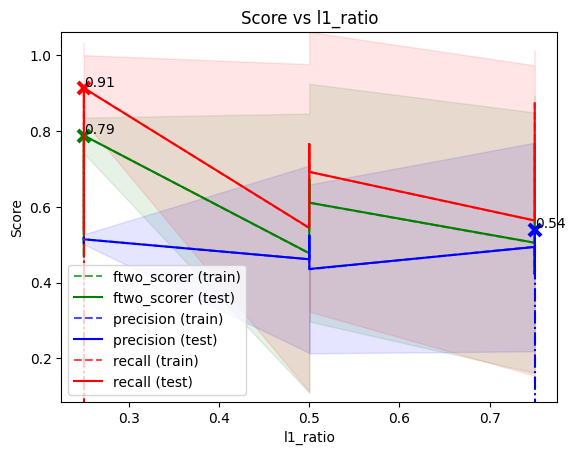

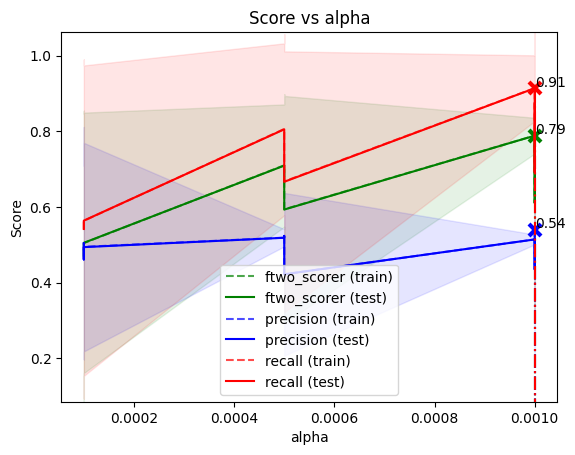

In [197]:
# Stochastic Gradient Descent Classifier
# Define the parameters to search over in dictionary form 
param_grid_sgd = {'l1_ratio': [0.25, 0.5, 0.75],'alpha': [ 0.0001, 0.0005, 0.001]}

# Setup the grid search
grid_sgd = GridSearchCV(estimator=SGDClassifier(random_state=random_state, penalty='elasticnet', early_stopping=True, max_iter=10000),
                    param_grid=param_grid_sgd,
                    scoring=scoring,
                    refit='ftwo_scorer',
                    cv=5,
                    n_jobs=-1,
                    return_train_score=True,
                    verbose=1) 

# Fit the grid search to the data
grid_sgd.fit(X_train, y_train)

# Find the best parameters
print(f"The best parameter values are: {grid_sgd.best_params_}")
print(f"With a score of: {grid_sgd.best_score_*100:.2f}%")

# Get results
results = grid_sgd.cv_results_

# Set the model to be the best estimator
best_sgd = grid_sgd.best_estimator_
# Fit the best model
best_sgd = best_sgd.fit(X_train, y_train)
# Find the best model scores on our single test split
print(f"Best model score on single split of the data: {best_sgd.score(X_test, y_test)*100:.2f}%")

# Save model using joblib
dump(best_sgd, "stochastic_gradient_descent_best.joblib")

# Plot results for each parameter
for param in param_grid_sgd.keys():
    plot_score_vs_param(results, scoring, param)

#### Logistic Regression Classifier model (hyper parameters tested = l1_ratio and C)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best parameter values are: {'C': 0.5, 'l1_ratio': 0.75}
With a score of: 69.29%
Best model score on single split of the data: 61.07%


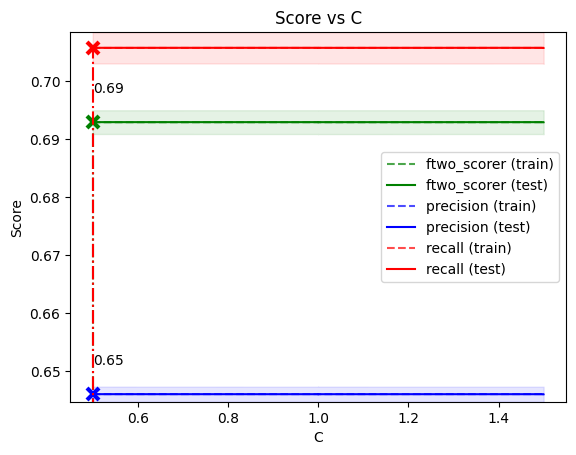

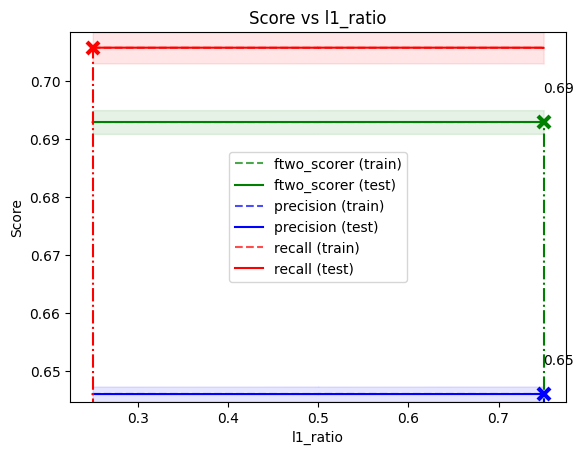

In [198]:
# Logistic Regression Classifier
# Define the parameters to search over in dictionary form 
param_grid_lr = {'C': [0.5, 1, 1.5],'l1_ratio': [0.25, 0.5, 0.75]}

# Setup the grid search
grid_lr = GridSearchCV(estimator=LogisticRegression(random_state=random_state, penalty='elasticnet', solver='saga', max_iter=10000),
                    param_grid=param_grid_lr,
                    scoring=scoring,
                    refit='ftwo_scorer',
                    cv=5,
                    n_jobs=-1,
                    return_train_score=True,
                    verbose=1) 

# Fit the grid search to the data
grid_lr.fit(X_train, y_train)

# Find the best parameters
print(f"The best parameter values are: {grid_lr.best_params_}")
print(f"With a score of: {grid_lr.best_score_*100:.2f}%")

# Get results
results = grid_lr.cv_results_

# Set the model to be the best estimator
best_lr = grid_lr.best_estimator_
# Fit the best model
best_lr = best_lr.fit(X_train, y_train)
# Find the best model scores on our single test split
print(f"Best model score on single split of the data: {best_lr.score(X_test, y_test)*100:.2f}%")

# Save model using joblib
dump(best_lr, "logistic_regression_best.joblib")

# Plot results for each parameter
for param in param_grid_lr.keys():
    plot_score_vs_param(results, scoring, param)

#### Random Forest Classifier model (hyper parameters tested = n_estimators and min_samples_split)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best parameter values are: {'min_samples_split': 2, 'n_estimators': 200}
With a score of: 98.61%
Best model score on single split of the data: 98.13%


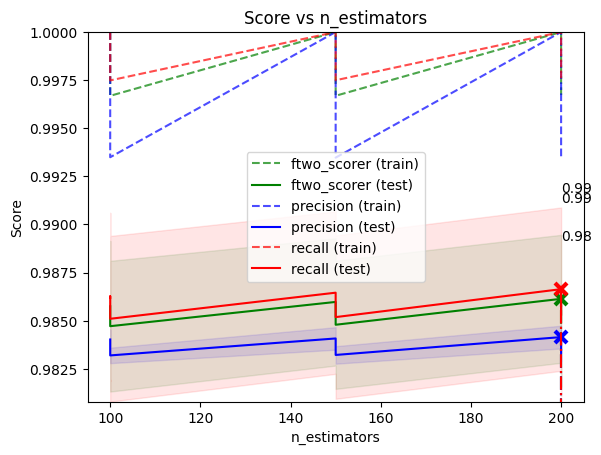

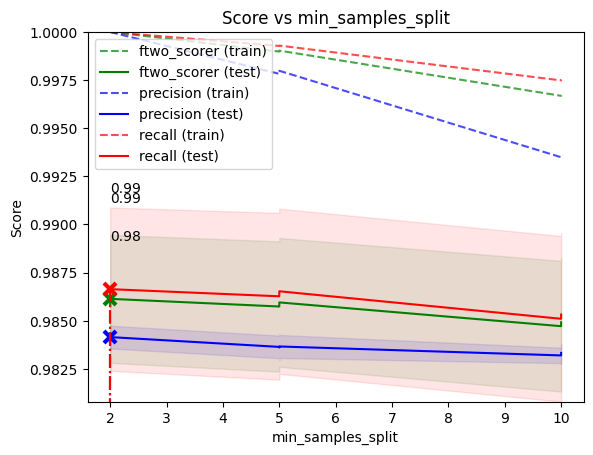

In [199]:
# Random Forest Classifier
# Define the parameters to search over in dictionary form 
param_grid_rf = {'n_estimators': [100, 150, 200],'min_samples_split': [2, 5, 10]}

# Setup the grid search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=random_state),
                    param_grid=param_grid_rf,
                    scoring=scoring,
                    refit='ftwo_scorer',
                    cv=5,
                    n_jobs=-1,
                    return_train_score=True,
                    verbose=1) 

# Fit the grid search to the data
grid_rf.fit(X_train, y_train)

# Find the best parameters
print(f"The best parameter values are: {grid_rf.best_params_}")
print(f"With a score of: {grid_rf.best_score_*100:.2f}%")

# Get results
results_rf = grid_rf.cv_results_

# Set the model to be the best estimator
best_rf = grid_rf.best_estimator_
# Fit the best model
best_rf = best_rf.fit(X_train, y_train)
# Find the best model scores on our single test split
print(f"Best model score on single split of the data: {best_rf.score(X_test, y_test)*100:.2f}%")

# Save model using joblib
dump(best_rf, "random_forest_best.joblib")

# Plot results for each parameter
for param in param_grid_rf.keys():
    plot_score_vs_param(results_rf, scoring, param)

## Task C: Model Performance Analysis
Based on the results from Task B, the best model was the random model with parameters min_samples_split=2 and n_estimators=200, which gave an f-beta score of 98.13%. The advanced metrics that I computed were composite metrics (precision-recall curve) and sensitivity analysis (plotted above, and again below). Based on these findings, it appears that the model performs perfectly on the train set, but poorly on the test set. This indicates overfitting, and suggests that further experiments can be conducted in regularization and hyperparamter tuning to reduce the overfitting. Additionally, the difference in fraud/non-fraud proportions in the train set (with SMOTE) and the test set may contribute to the difference in performance.

#### Composite metrics - precision-recall curve

Train data classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    218293
           1       1.00      1.00      1.00    218293

    accuracy                           1.00    436586
   macro avg       1.00      1.00      1.00    436586
weighted avg       1.00      1.00      1.00    436586

Test data classification report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     72765
           1       0.12      0.40      0.19       396

    accuracy                           0.98     73161
   macro avg       0.56      0.69      0.59     73161
weighted avg       0.99      0.98      0.99     73161

Train data confusion matrix
[[218293      0]
 [     0 218293]]
Test data confusion matrix
[[71634  1131]
 [  236   160]]


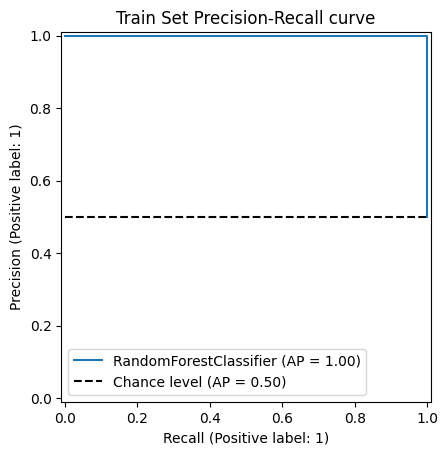

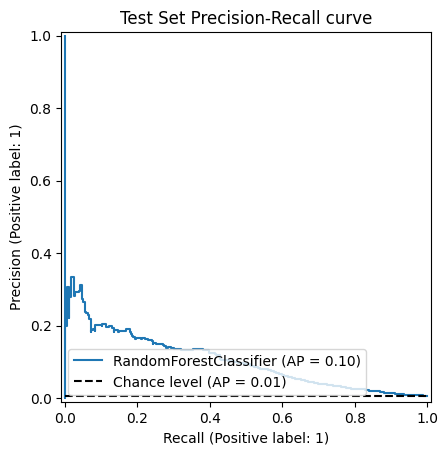

In [202]:
# Composite Metrics
from sklearn.metrics import PrecisionRecallDisplay, confusion_matrix

# Best model (already trained)
clf = best_rf
# Predict
y_pred_train = clf.predict(X=X_train)
y_pred_test = clf.predict(X=X_test)

# Create a classification report
print('Train data classification report')
print(classification_report(y_train, y_pred_train))
print('Test data classification report')
print(classification_report(y_test, y_pred_test))
# Create a confusion matrix
print('Train data confusion matrix')
print(confusion_matrix(y_train, y_pred_train))
print('Test data confusion matrix')
print(confusion_matrix(y_test, y_pred_test))

# Plot train set precision-recall curve
display = PrecisionRecallDisplay.from_estimator(
    clf, X_train, y_train, name="RandomForestClassifier", plot_chance_level=True
)
_ = display.ax_.set_title("Train Set Precision-Recall curve")

# Plot test set precision-recall curve
display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="RandomForestClassifier", plot_chance_level=True
)
_ = display.ax_.set_title("Test Set Precision-Recall curve")

#### Sensitivity Analysis - f-beta score, recall, and precision vs min_samples_split and n_estimators

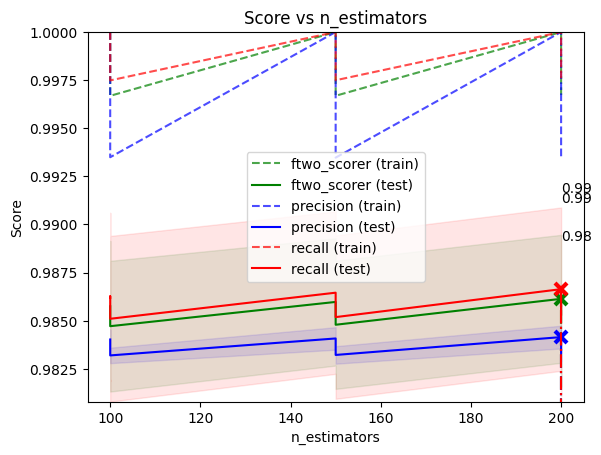

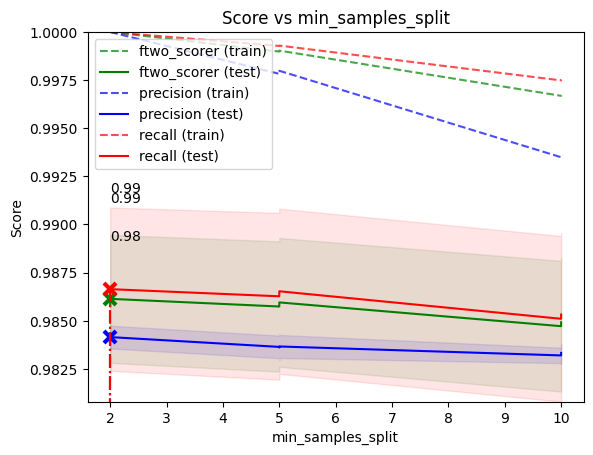

In [201]:
# Sensitivity Analysis
# Plot results for each parameter
for param in param_grid_rf.keys():
    plot_score_vs_param(results_rf, scoring, param)

In [205]:
# Load a saved joblib model and evaluate it
best_rf_saved = load("../models/random_forest_best.joblib")
print(f"Loaded joblib model f1-score: {best_rf_saved.score(X_test, y_test) * 100:.2f}%")

Loaded joblib model prediction score: 98.13%
